In [62]:
import os
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.lib.io import file_io
from tensorflow.contrib.factorization import WALSMatrixFactorization
from tensorflow.contrib.learn.python.learn import learn_runner

In [63]:
PROJECT = 'qwiklabs-gcp-4a684069c4776675'
BUCKET = 'colaborative-filtering-agea'
REGION = 'us-east1'
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = '1.8'

In [64]:
def find_top_k(user, item_factors, k):
  all_items = tf.matmul(tf.expand_dims(user, 0), tf.transpose(item_factors))
  topk = tf.nn.top_k(all_items, k=k)
  return tf.cast(topk.indices, dtype=tf.int64)

def batch_predict(args):
  with tf.Session() as sess:
    estimator = WALSMatrixFactorization(
        num_rows=args['nusers'],
        num_cols=args['nitems'],
        embedding_dimension=args['n_embeds'],
        model_dir=args['model_dir']
    )
    
    user_factors = tf.convert_to_tensor(estimator.get_row_factors()[0]) # (nusers, nembeds)
    item_factors = tf.convert_to_tensor(estimator.get_col_factors()[0])# (nitems, nembeds)
    # for each user, find the top K items
    topk = tf.squeeze(tf.map_fn(lambda user: find_top_k(user, item_factors, args['topk']), user_factors, dtype=tf.int64))
    with file_io.FileIO(os.path.join(args['output_dir'], 'batch_pred.txt'), mode='w') as f:
      for best_items_for_user in topk.eval():
        f.write(','.join(str(x) for x in best_items_for_user) + '\n')

In [65]:
batch_predict({
    'model_dir': 'gs://{}/wals/model_trained'.format(BUCKET),
    'output_dir': 'gs://{}/wals/data'.format(BUCKET),
    'nitems': 18716,
    'nusers': 1086609,
    'n_embeds': 10,
    'topk': 3
  })

Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f684dedf290>, '_model_dir': 'gs://colaborative-filtering-agea/wals/model_trained', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_save_summary_steps': 100, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}


In [66]:
!gsutil cat -r 0-500 gs://{BUCKET}/wals/data/batch_pred.txt 

1064,146,339
368,724,708
1463,1091,2214
368,1091,502
337,129,206
742,2933,1263
530,1091,206
1974,635,1472
823,2933,368
206,530,337
931,585,1588
901,812,566
668,901,812
389,368,1649
1387,1913,502
1913,1091,1142
438,1833,1021
519,1061,136
901,1387,566
92,724,368
1073,808,980
230,1387,256
1635,1833,368
1342,206,337
1387,1036,1091
1065,530,1142
1061,1440,1104
1064,146,1223
1065,230,1648
901,566,812
139,1091,450
230,1387,368
1064,808,146
1061,389,1440
368,92,708
577,1065,1036
1064,146,249
1978,530,591

In [67]:
def get_factors(args):
  with tf.Session() as sess:
    estimator = WALSMatrixFactorization(
      num_rows=args['nusers'], num_cols=args['nitems'],
      embedding_dimension=args['n_embeds'],
      model_dir=args['model_dir']
    )
    row_factors = estimator.get_row_factors()[0]
    col_factors = estimator.get_col_factors()[0]
    return row_factors, col_factors

In [68]:
args = {
    'model_dir': 'gs://{}/wals/model_trained'.format(BUCKET),
    'nitems': 18716,
    'nusers': 1086609,
    'n_embeds': 10
  }

user_embeddings, item_embeddings = get_factors(args)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f684deebf50>, '_model_dir': 'gs://colaborative-filtering-agea/wals/model_trained', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_save_summary_steps': 100, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}


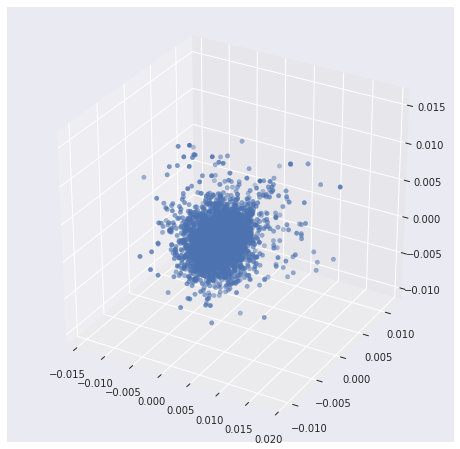

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(user_embeddings)
user_embeddings_pca = pca.transform(user_embeddings)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
xs, ys, zs = user_embeddings_pca[::150].T
ax.scatter(xs, ys, zs)

In [44]:
!mkdir data

In [69]:
!gsutil cp gs://{BUCKET}/wals/data/* ./data

Copying gs://colaborative-filtering-agea/wals/data/batch_pred.txt...
Copying gs://colaborative-filtering-agea/wals/data/collab_mapped.csv...         
Copying gs://colaborative-filtering-agea/wals/data/collab_raw.csv...            
Copying gs://colaborative-filtering-agea/wals/data/items.csv...                 
/ [4 files][  1.4 GiB/  1.4 GiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://colaborative-filtering-agea/wals/data/items_for_user...
Copying gs://colaborative-filtering-agea/wals/data/users.csv...                 
Copying gs://colaborative-filtering-agea/wals/data/users_for_item...            
\ [7 files][  2.0 GiB/  2.0 GiB]   96.8 MiB/s                                   
Operation completed over 7 objects/2.0 GiB.

In [70]:
!head data/items.csv

-ZPRbaCoz,7347
86sLs-KS_,6594
5I5k5XSIN,12072
QiH_Sd23-,15485
8_NNrmRnu,7332
FBODmTGeK,17156
pNlNYlDZl,14624
NYvFM_Vl4,16705
g6bEFs-iG,8156
ohG-9hNIk,11846


In [32]:
import csv
def create_mapping(filename):
  with open(filename, 'r') as csvfile:
    index_to_id = {}
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        index_to_id[row[1]] = row[0]
  return index_to_id

user_index_to_id = create_mapping('data/users.csv')
item_index_to_id = create_mapping('data/items.csv')

In [113]:
df = pd.read_csv('data/batch_pred.txt',  header=None)
df.head()

,0,1,2
0,1064,146,339
1,368,724,708
2,1463,1091,2214
3,368,1091,502
4,337,129,206


In [114]:
! head data/batch_pred.txt

1064,146,339
368,724,708
1463,1091,2214
368,1091,502
337,129,206
742,2933,1263
530,1091,206
1974,635,1472
823,2933,368
206,530,337


In [115]:
!ls data

batch_pred.txt	   items.csv			    users.csv
collab_mapped.csv  items_for_user		    users_for_item
collab_raw.csv	   recommended-articles-mapped.csv


In [116]:
for column in df.columns:
  df[column] = df[column].apply(lambda index: item_index_to_id[(str(index))])

In [117]:
df.head()

,0,1,2
0,iX3X6tNDk,-yn-SCmEb,xhaWlfFsJ
1,0fYpABrXb,cGl_BoPtW,AYfFjDSci
2,VIpEwhPg5,YrpZD2B-o,Lo6wpP_2V
3,0fYpABrXb,YrpZD2B-o,Pzk2UKyZk
4,FmEAF-myl,6j10Sd240,4TLebQRBG


In [118]:
users_index = [str(i) for i in range(len(df))]
df['user_id'] = map(lambda index: user_index_to_id.get(index),users_index)
df.head()

,0,1,2,user_id
0,iX3X6tNDk,-yn-SCmEb,xhaWlfFsJ,3127735
1,0fYpABrXb,cGl_BoPtW,AYfFjDSci,1402547
2,VIpEwhPg5,YrpZD2B-o,Lo6wpP_2V,4424328
3,0fYpABrXb,YrpZD2B-o,Pzk2UKyZk,3604872
4,FmEAF-myl,6j10Sd240,4TLebQRBG,3627874


In [122]:
df.to_csv('data/recommended-articles-mapped.csv',index=False)


In [124]:
!gsutil cp data/recommended-articles-mapped.csv gs://{BUCKET}/wals/data

Copying file://data/recommended-articles-mapped.csv [Content-Type=text/csv]...
- [1 files][ 39.4 MiB/ 39.4 MiB]                                                
Operation completed over 1 objects/39.4 MiB.                                     


In [123]:
! head data/recommended-articles-mapped.csv

0,1,2,user_id
iX3X6tNDk,-yn-SCmEb,xhaWlfFsJ,3127735
0fYpABrXb,cGl_BoPtW,AYfFjDSci,1402547
VIpEwhPg5,YrpZD2B-o,Lo6wpP_2V,4424328
0fYpABrXb,YrpZD2B-o,Pzk2UKyZk,3604872
FmEAF-myl,6j10Sd240,4TLebQRBG,3627874
FOIVMpCUe,jSOes3ZLw,ianIQDGsG,3862440
Qkrub5W13,YrpZD2B-o,4TLebQRBG,4961169
U4DXwSu00,2d7eYMo6G,X5vYQVmaJ,3853869
WL4mkK9Qj,jSOes3ZLw,0fYpABrXb,4491186


In [125]:
! wc -l data/recommended-articles-mapped.csv

1086610 data/recommended-articles-mapped.csv
